# Welcome to PunPal API, your punny assistant.<br>
To use this API, click Runtime->Run All. Then scroll all the way to the end of this file and change the input sentence and/or model. Then only run the last cell.

In [ ]:
!pip install transformers #installing because we want to use pre_trained models, both from huggingface and our own models
!wget https://github.com/DavVratChadha/NoPunIntended/raw/main/data/tag_dict.pickle #loading the relative frequency heuristic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.6 MB/s eta 0:00:00
--2023-04-14 05:23:27--  https://github.com/DavVratChadha/NoPunIntended/raw/main/data/tag_dict.pickle
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavVratChadha/NoPunIntended/main/data/tag_dict.pickle [following]
--2023-04-14 05:23:28--  https://raw.githubusercontent.com/DavVratChadha/NoPunIntended/main/data/tag_dict.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.

In [ ]:
import pickle
import torch
import re
import transformers
from transformers import RobertaTokenizer, DebertaTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

In [ ]:
import spacy
!python -m spacy download en_core_web_lg

2023-04-14 05:23:56.944025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning) #ignoring UserWarning from colab because I know what I am doing here
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = '/content/drive/My Drive/ESC324projectdrive/dav/'

In [ ]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.add_pipe('sentencizer')

rel_freq = load_pickle('tag_dict.pickle')

#Original Tokenizers
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

#Our Fine-Tuned Models
roberta_model = AutoModelForSequenceClassification.from_pretrained("DVC12/NoPunIntended_RoBERTa")
deberta_model = AutoModelForSequenceClassification.from_pretrained("DVC12/NoPunIntended_DeBERTa")

In [ ]:
def sentence_processor(sentence):
  """Helper function to process the input sentence by fixing punctuation and POS tagging it"""
  unprocessed_sentence = []
  processed_sentence = []

  #remove extra spaces using rejex
  sentence = re.sub(' +', ' ', sentence)
  #replace ' m with 'm
  sentence = sentence.replace("' m", "'m")
  #replace ' s with 's
  sentence = sentence.replace("' s", "'s")
  #replace ' ve with 've
  sentence = sentence.replace("' ve", "'ve")
  #replace ' re with 're
  sentence = sentence.replace("' re", "'re")        
  #replace ' d with 'd
  sentence = sentence.replace("' d", "'d")
  #replace ' ll with 'll
  sentence = sentence.replace("' ll", "'ll")
  #replace ' t with 't
  sentence = sentence.replace("' t", "'t")
  #replace '' with "
  sentence = sentence.replace("''", "\"")
  
  #remove new line character at the end of the sentence
  sentence = sentence.strip()
  sentence = nlp(sentence)
  for sent in sentence.sents:
      for token in sent:
          #Write "/POS" after each token.
          #Split tokens with spaces.
          token.lemma_ = token.lemma_.lower()
          #replace pun with its lemma
          processed_sentence.append(token.lemma_ + "/" + token.tag_)
          unprocessed_sentence.append(token.text)
  return [processed_sentence, unprocessed_sentence]

In [ ]:
def roberta_predictor(input_list, print_output):
  pos_sentence = input_list[0]
  sentence = input_list[1]
  max_len = 79 #dont change
  #creating an array of heuristic based on rel_freq mapping for each tag in pos_sentence
  rel_freq_heuristic = [0]
  for word in pos_sentence:
    rel_freq_heuristic.append(rel_freq.get(word.split("/")[1], 0))
  rel_freq_heuristic += [0]*(max_len - len(rel_freq_heuristic))
  rel_freq_heuristic = torch.tensor(rel_freq_heuristic)

  k_means_output = []

  encoded_data = roberta_tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length = max_len, #we are padding all sentences to a max_len elements (words + punction)
          pad_to_max_length = True,
          return_attention_mask = False,
          return_tensors='pt',
          truncation = True
      )

  temp = np.array(encoded_data['input_ids'][0].tolist().copy())
  temp = temp[temp != temp[-1]] #remove padding

  multiplier = 0.5 #you can change this value to affect how the test model works. This is a hyperparameter which changes the max number of clusters for kmeans
  #mutliplier has been set to 0.5 because RoBERTa was fine-tuned by us with this value
  num_clusters = max(math.ceil(len(temp)*multiplier), min(5, len(sentence)))

  kmeans = KMeans(n_clusters = num_clusters, n_init = 10)
  kmeans.fit(temp.reshape(-1, 1))
  att_labels = np.array(kmeans.labels_)
  k_means_output.append(kmeans.labels_)
  
  if print_output: #graph k-means
    cluster_centers = kmeans.cluster_centers_.squeeze(-1)
    cluster_sizes = np.bincount(kmeans.labels_)

    # Add circles with the same colors for points with the same label
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k',  'navy', 'teal', 'maroon', 'purple', 'olive', 'silver',  'mediumblue', 'lime', 'tomato', 'orchid', 'gold', 'gray',  'dodgerblue', 'darkgreen', 'deeppink', 'royalblue', 'sienna', 'darkorange',  'hotpink', 'turquoise', 'limegreen', 'cornflowerblue', 'sandybrown']
    k = 0
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(25, 1))

    used_colors = {}
    # Plot the data points with the corresponding colors
    for i in range(len(cluster_centers)):
      if cluster_centers[i] in used_colors:
        use_color = used_colors[cluster_centers[i]]
      else:
        used_colors[cluster_centers[i]] = colors[k]
        k += 1
      ax.scatter(temp[i], 0, color = used_colors[cluster_centers[i]], s = 35 * 1.5**cluster_sizes[i])
    ax.set_yticklabels([])
    # ax.set_xscale('log')
    plt.title("K-Means on Token_IDs for RoBERTa/DeBERTa on Linear Scale")
    plt.xlabel("Token_ID")
    # Show the plot
    plt.show()


  unique, count = (np.unique(att_labels, return_counts = True))

  idx = np.argsort(count)
  count = count[idx]
  unique = unique[idx]

  first_mode = unique[-1]
  attention_mask = torch.tensor([0] * max_len)
  indices = np.where(att_labels == first_mode)
  attention_mask[indices] = 1

  
  lone_word = unique[np.where(count == 1)]
  lone_word_ind = np.where(np.isin(att_labels, lone_word))[0]
  attention_mask[lone_word_ind] = 1

  if len(unique) > 1:
    second_lowest_chosen = unique[1]
    indices2 = np.where(att_labels == second_lowest_chosen)
    attention_mask[indices2] = 1
                                              
  input_id = torch.stack([encoded_data['input_ids'][0]], dim = 0)
  attention_mask = torch.stack([attention_mask], dim = 0)

  #use fine-tuned model
  model_output = roberta_model(input_id, attention_mask = attention_mask)
  model_output = torch.softmax(model_output["logits"].detach(), dim = 1) * rel_freq_heuristic
  sum = torch.sum(model_output)
  model_output = model_output/sum

  model_pred = torch.argmax(model_output, dim = 1)
  model_confidence = torch.max(model_output, dim = 1)
  #updating some values
  if model_pred == 0:
    model_pred = 1
  pred_pun = sentence[model_pred.item() - 1]
  model_confidence = model_confidence[0][0].item()*100
  return pred_pun, model_confidence

In [ ]:
def deberta_predictor(input_list, print_output):
  pos_sentence = input_list[0]
  sentence = input_list[1]
  max_len = 79 #dont change
  #creating an array of heuristic based on rel_freq mapping for each tag in pos_sentence
  rel_freq_heuristic = [0]
  for word in pos_sentence:
    rel_freq_heuristic.append(rel_freq.get(word.split("/")[1], 0))
  rel_freq_heuristic += [0]*(max_len - len(rel_freq_heuristic))
  rel_freq_heuristic = torch.tensor(rel_freq_heuristic)

  k_means_output = []

  encoded_data = deberta_tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length = max_len, #we are padding all sentences to a max_len elements (words + punction)
          pad_to_max_length = True,
          return_attention_mask = False,
          return_tensors='pt',
          truncation = True
      )

  temp = np.array(encoded_data['input_ids'][0].tolist().copy())
  temp = temp[temp != temp[-1]] #remove padding

  multiplier = 1 #you can change this value to affect how the test model works. This is a hyperparameter which changes the max number of clusters for kmeans
  #mutliplier has been set to 1 because deberta was fine-tuned by us with this value
  num_clusters = max(math.ceil(len(temp)*multiplier), min(5, len(sentence)))

  kmeans = KMeans(n_clusters = num_clusters, n_init = 10)
  kmeans.fit(temp.reshape(-1, 1))
  att_labels = np.array(kmeans.labels_)
  k_means_output.append(kmeans.labels_)

  unique, count = (np.unique(att_labels, return_counts = True))

  idx = np.argsort(count)
  count = count[idx]
  unique = unique[idx]

  first_mode = unique[-1]
  attention_mask = torch.tensor([0] * max_len)
  indices = np.where(att_labels == first_mode)
  attention_mask[indices] = 1
  
  lone_word = unique[np.where(count == 1)]
  lone_word_ind = np.where(np.isin(att_labels, lone_word))[0]
  attention_mask[lone_word_ind] = 1

  if len(unique) > 1:
    second_lowest_chosen = unique[1]
    indices2 = np.where(att_labels == second_lowest_chosen)
    attention_mask[indices2] = 1
                                              
  input_id = torch.stack([encoded_data['input_ids'][0]], dim = 0)
  attention_mask = torch.stack([attention_mask], dim = 0)

  #use fine-tuned model
  model_output = deberta_model(input_id, attention_mask = attention_mask)
  model_output = torch.softmax(model_output["logits"].detach(), dim = 1) * rel_freq_heuristic
  sum = torch.sum(model_output)
  model_output = model_output/sum
  model_pred = torch.argmax(model_output, dim = 1)
  model_confidence = torch.max(model_output, dim = 1)
  #updating some values
  if model_pred == 0:
    model_pred = 1
  pred_pun = sentence[model_pred.item() - 1]
  model_confidence = model_confidence[0][0].item()*100
  return pred_pun, model_confidence

In [ ]:
def PunPal(input_sentence = "", model_name = "ensemble", display_output = True):
  """This function acts as an API to test the models trained by us on any input sentence.
  Input:
      input_sentence: <your sentence>
      model_name: roberta / deberta / ensemble
      display_output (optional): True / False
  Output:
      model_pred: Predicted pun word
      model_confidence: Confidence rate of a word being a pun
  """
  if len(input_sentence) == 0:
    print("Invalid sentence")
    return None, None

  #POS tagging
  output_list = sentence_processor(input_sentence)
  
  roberta_pred, roberta_conf = roberta_predictor(output_list, display_output)
  deberta_pred, deberta_conf = deberta_predictor(output_list, display_output)
  
  if display_output:
    print()
    print("RoBERTa predicts that the Pun word is '", roberta_pred, "' with confidence = ", roberta_conf, "%")
    print("DeBERTa predicts that the Pun word is '", deberta_pred, "' with confidence = ", deberta_conf, "%")
  
  if model_name == "roberta":
    return roberta_pred, roberta_conf

  elif model_name == "deberta":
    return deberta_pred, deberta_conf
  
  elif model_name == "ensemble":
    if roberta_conf > deberta_conf:
      return roberta_pred, roberta_conf
    else:
      return deberta_pred, deberta_conf
  else:
    print("Invalid Model name")
    return None, None

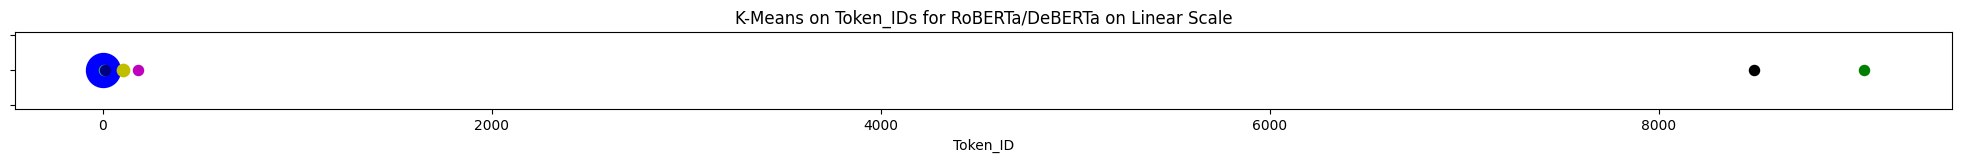


RoBERTa predicts that the Pun word is ' takeoff ' with confidence =  98.8405896211934 %
DeBERTa predicts that the Pun word is ' takeoff ' with confidence =  99.84886934429838 %


In [ ]:
#model = roberta / deberta / ensemble
#input = <your sentence>
#display_output (optional) = True / False

model = "roberta"
input = "Two airline pilots in a stand-up comedy did a takeoff."
pred, conf = PunPal(input_sentence = input, model_name = model)

#Note: pred and conf depend on the model chosen, whereas the output below are for both model and can be turned off by setting display_output = False
#Note2: Circles on graph below represent the centroid location of a K-Means cluster for token_id of words with similar context. Larger Radii implies larger cluster

Here are some Puns from our test dataset if you cannot think of a pun right now:<br>
**Homophonic Puns:**<br>
* What keeps a dock floating above water? Pier pressure.
* Legends tell us that a weakness of the carnivorous vampire is a steak.
* There' s nothing to stop me putting things in tins, said Tom cannily.
* The pistol of a flower is its only protections against insects.
* Psychiatrists like Kentucky Freud Chicken.
* Hotel owners usually have suite dreams.
* The telemarketer asked me if I read magazines at all and I replied that I did, periodically.
* She became an art dealer because she wanted more Monet.
* 7 days without prayer makes 1 weak
* You should never take rocks for granite.
* ''If I let go of the ceiling it will collapse,'' Tom upheld.

**Heterophonic/Semantic Puns:**<br>
* Did you hear about the crime that happened in a parking garage? It was wrong on so many levels.
* Two astronauts who were dating put an end to it because they both needed their space.
* Luggage salespeople have to make a good case for you to buy.
* A kettle on the stove was singing' Home on the Range'.
* Musical mechanics always sing in parts.
* Hubble wanted to bring the idea into better focus.
* The forecaster was away because he was under the weather.
* Two airline pilots in a stand-up comedy did a takeoff.